# Plot figure 1

In [1]:
import os
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re


## Data preparation

### Definitions

In [2]:
# dictionary definitions

data_dic = {0: "blds_continent_data_18-23_ai.json",
            1: "blds_africa_states_18-23_ai.json",
            2: "blds_northamerica_states_18-23_ai.json",
            3: "blds_europe_states_18-23_ai.json",
            4: "blds_asia_states_18-23_ai.json",}
geojson_folder_dic = {0: "geojson-continent-states",
                      1: "geojson-africa-states",
                      2: "geojson-northamerica-states",
                      3: "geojson-europe-states",
                      4: "geojson-asia-states",}

In [3]:
# user input definition

while True:
    try:
        user_d_spec = int(input("Which data do you want to plot?\
                            Enter 0 for stats by continents (2018–2023),\
                            1 for stats by Africa states (2018–2023),\
                            2 for stats by North-Central America states (2018–2023),\
                            3 for stats by Europe states (2018–2023),\
                            4 for stats by Asia states (2018–2023):"
                                ))
    except ValueError:
        print("Please enter a number.")
        continue
    if user_d_spec not in range(len(data_dic)):
        print("Please enter 0, 1, 2, 3 or 4.")
        continue
    break


In [4]:
# function definitions

def data_spec(data_dic):
    
    try:
        with open(f"downloaded-data\\{data_dic}", "r") as f:
            data = json.load(f)
        return data
    except Exception as e:
        print(e)
        print("Please download the data first.")


def get_geojson_names(home_dir, geojson_folder_dic):
    geojson_dir = os.path.join(
        home_dir, f"geojson-regions\\{geojson_folder_dic}", "")

    geojson_names = []
    for (dir_path, dir_names, file_names) in os.walk(geojson_dir):  # give the path
        geojson_names.extend(file_names)
    print(geojson_names)
    return geojson_names


### Load the data

In [5]:
os.chdir('..')

data = data_spec(data_dic[user_d_spec])

home_dir = os.getcwd()


### Edit the obtained data into desired shape to create a DataFrame

In [6]:
d = {
    "feature": [],
    "source": [],
    "timestamp": [],
    "value": []
}


In [7]:
for cont in data:
    for dic1 in cont:
        feature, source = dic1["groupByObject"][0], dic1["groupByObject"][1]
        for res in dic1["result"]:
            d["feature"].append(feature)
            d["source"].append(source)
            d["timestamp"].append(res["timestamp"])
            d["value"].append(res["value"])

df = pd.DataFrame(d)
# df

In [8]:
# extract only the year
df["year"] = pd.to_datetime(df["timestamp"]).dt.year

### Append the names of the regions to the DataFrame

In [9]:
# extract the geojson IDs and the names
geojson_names = get_geojson_names(home_dir, geojson_folder_dic[user_d_spec])


['0_Costa Rica.geojson', '10_Mexico.geojson', '11_Belize.geojson', '12_Panama.geojson', '13_Bahamas.geojson', '14_Trinidad and Tobago.geojson', '15_Grenada.geojson', '16_St. Vin. and Gren..geojson', '17_Barbados.geojson', '18_Saint Lucia.geojson', '19_Dominica.geojson', '1_Nicaragua.geojson', '20_Antigua and Barb..geojson', '21_St. Kitts and Nevis.geojson', '22_Jamaica.geojson', '23_Bajo Nuevo Bank.geojson', '24_Serranilla Bank.geojson', '2_Haiti.geojson', '3_Dominican Rep..geojson', '4_El Salvador.geojson', '5_Guatemala.geojson', '6_Cuba.geojson', '7_Honduras.geojson', '8_United States of America.geojson', '9_Canada.geojson']


In [10]:
geojson_names_2 = geojson_names

id_name_dic = {int(re.search(r'^\d+', k)[0]): re.search(r'\_.+\.', v)[0][1:-1] # using lib RegularExpression to separate the ID number and the state name
                for k, v in zip(geojson_names, geojson_names_2)}
id_name_ser = pd.Series(id_name_dic)
id_name_df = pd.DataFrame(id_name_ser, columns=["name"])
id_name_df = id_name_df.reset_index().rename(columns={"index": "id"})
id_name_df["id"] = id_name_df["id"].astype(int)
# id_name_df


In [11]:
# merge df with region names based on IDs
df = df.merge(id_name_df, how="left", left_on="feature",
               right_on="id")
# df.head(20)

### Filtering the data

In [13]:
# exclude states which give zero in total
# df = df.groupby("name", "source").filter(
#     lambda x: x["value"].sum() != 0)


In [14]:
# get the number of AI Microsoft (source=microsoft/BuildingFootprints) / manually mapped (remainder) buildings for every year
grouped = df.groupby(["name", "year"])["value"].sum()
# grouped

In [15]:
grouped


name                      year
Antigua and Barb.         2018       38555.0
                          2019       38930.0
                          2020       39053.0
                          2021       38941.0
                          2022       39085.0
                                     ...    
United States of America  2019    27680676.0
                          2020    33284840.0
                          2021    40888985.0
                          2022    49029980.0
                          2023    57901774.0
Name: value, Length: 150, dtype: float64

In [16]:
# merge the DataFrame with groupBy DataFrame and compute the percentage
merged_data = df.merge(grouped, on=["name", 'year'], how='left', )
merged_data = merged_data.rename(columns={"value_x":"num_of_blds", "value_y":"total_blds"})
merged_data["percentage"] = (merged_data["num_of_blds"] / merged_data["total_blds"]) * 100
# merged_data.head(10)


In [17]:
# percentage verification
merged_data.groupby(["name", "year"])["percentage"].sum()


name                      year
Antigua and Barb.         2018    100.0
                          2019    100.0
                          2020    100.0
                          2021    100.0
                          2022    100.0
                                  ...  
United States of America  2019    100.0
                          2020    100.0
                          2021    100.0
                          2022    100.0
                          2023    100.0
Name: percentage, Length: 150, dtype: float64

In [18]:
# create the dataframe by the source
df_ai = merged_data.loc[(df["source"] == "source=microsoft/BuildingFootprints") , :] # buiildings used from Microsoft AI
df_rem = merged_data.loc[(df["source"] == "remainder"),:] # remainder = manually mapped buildings
# df_ai.head()


In [19]:
# exclude states which give zero in total
df_rem = df_rem.groupby("name").filter(
    lambda x: x["num_of_blds"].sum() != 0)
df_ai = df_ai.groupby("name").filter(
    lambda x: x["num_of_blds"].sum() != 0)


In [20]:
# verify the sum
# df_rem.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [21]:
# verify the sum
# df_ai.groupby("name")["num_of_blds"].sum().sort_values(ascending=True)


In [22]:
# how the DataFrame looks like – manually mapped buildings
df_rem.head()


,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
0,0,remainder,2018-01-01T00:00:00Z,61906.0,2018,0,Costa Rica,61906.0,100.0
1,0,remainder,2019-01-01T00:00:00Z,76289.0,2019,0,Costa Rica,76289.0,100.0
2,0,remainder,2020-01-01T00:00:00Z,86564.0,2020,0,Costa Rica,86564.0,100.0
3,0,remainder,2021-01-01T00:00:00Z,106221.0,2021,0,Costa Rica,106221.0,100.0
4,0,remainder,2022-01-01T00:00:00Z,134409.0,2022,0,Costa Rica,134409.0,100.0


In [23]:
# how the DataFrames look like – AI Microsoft buildings
df_ai.head()

,feature,source,timestamp,num_of_blds,year,id,name,total_blds,percentage
6,0,source=microsoft/BuildingFootprints,2018-01-01T00:00:00Z,0.0,2018,0,Costa Rica,61906.0,0.0
7,0,source=microsoft/BuildingFootprints,2019-01-01T00:00:00Z,0.0,2019,0,Costa Rica,76289.0,0.0
8,0,source=microsoft/BuildingFootprints,2020-01-01T00:00:00Z,0.0,2020,0,Costa Rica,86564.0,0.0
9,0,source=microsoft/BuildingFootprints,2021-01-01T00:00:00Z,0.0,2021,0,Costa Rica,106221.0,0.0
10,0,source=microsoft/BuildingFootprints,2022-01-01T00:00:00Z,0.0,2022,0,Costa Rica,134409.0,0.0


## Plots

In [24]:
def fill_under_lines(*argv, alpha=.2, **kwargs):
    for ax in argv:
        if ax is None:
            ax = plt.gca()
        for line in ax.lines:
            x, y = line.get_xydata().T
            ax.fill_between(x, 0, y, color=line.get_color(), alpha=alpha, **kwargs)

In [25]:
# prepare DataFrame of labels to the end of lines

df_last_rem = df_rem.groupby("name")[["num_of_blds", "year"]].last().reset_index()
df_last_ai = df_ai.groupby("name")[["num_of_blds", "year"]].last().reset_index()
# df_last_rem

### Manually mapped buildings

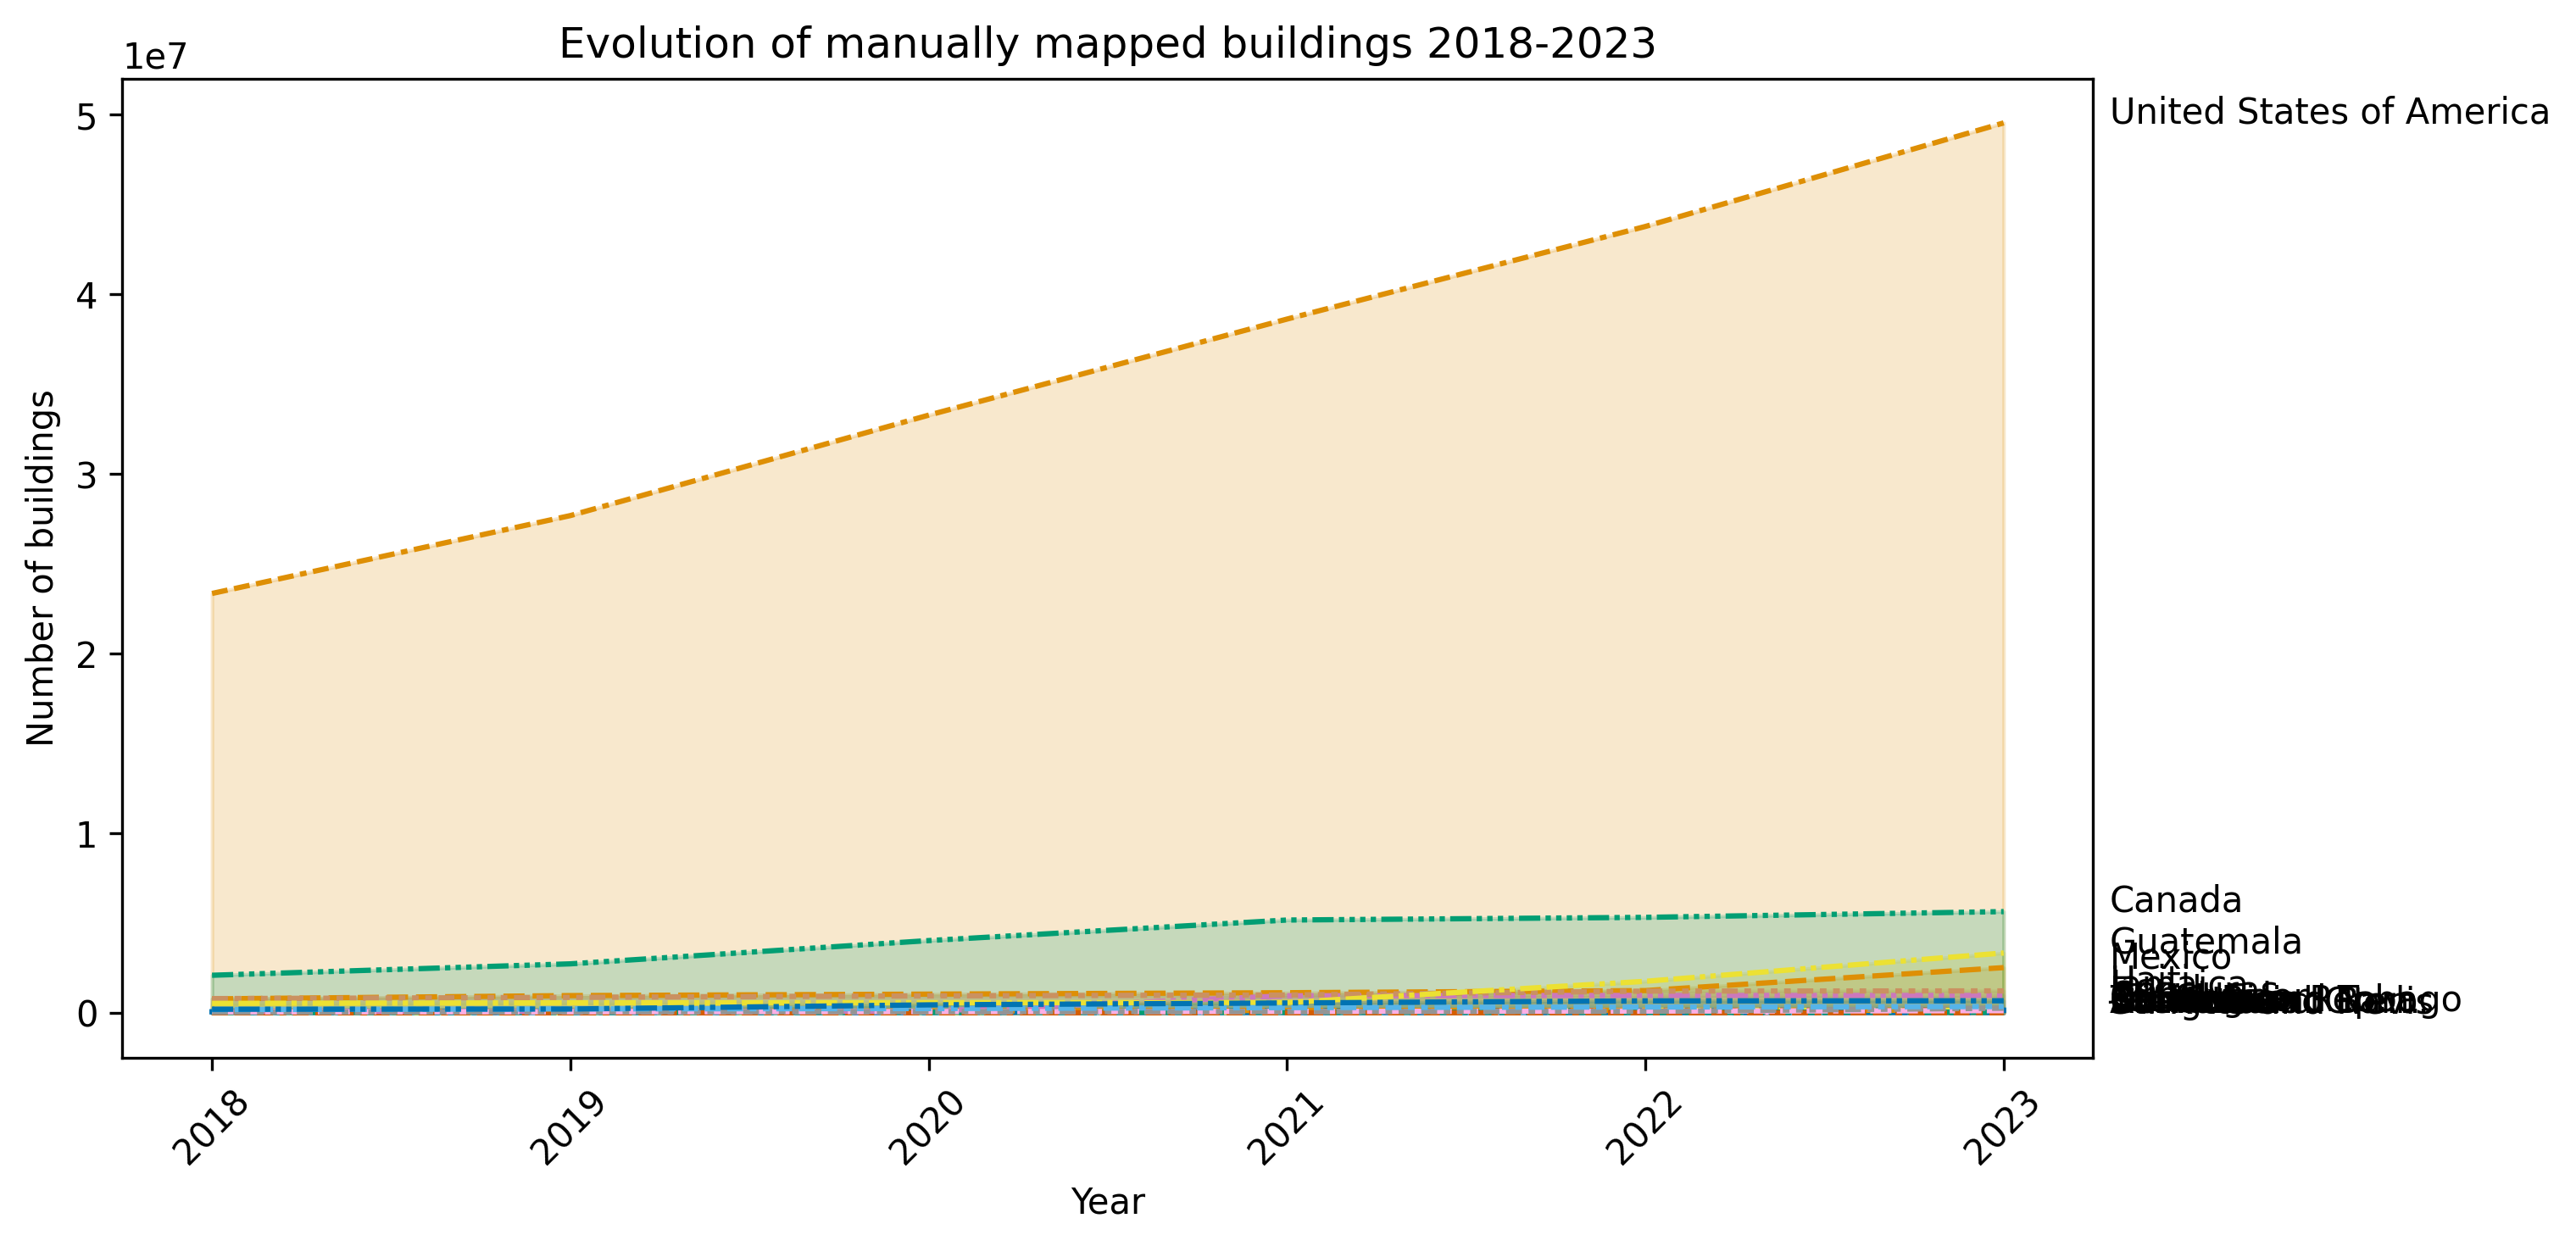

In [26]:
# test for labels at the line

plt.figure(figsize=(10, 5), dpi=300)
plt.title("Evolution of manually mapped buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_rem,
                  palette='colorblind',  style='name', legend=False
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# add number annotations
# for index, row in df_rem.iterrows():
#     ax.annotate(round(row['num_of_blds']),
#                 (row['year'], row['num_of_blds']))

# add annotations in the end of the lines
for i in range(len(df_last_rem)):
    ax.annotate(df_last_rem.iloc[i]['name'], xy=(df_last_rem.iloc[i]["year"], df_last_rem.iloc[i]
                ['num_of_blds']), xytext=(30, 0), textcoords='offset points', color='black',)

# add colorful annotation
# for line, name in zip(ax.lines, df_last_rem["name"]):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                 xycoords=ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")


# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")

plt.show()


Text(0, 0.5, 'Number of buildings')

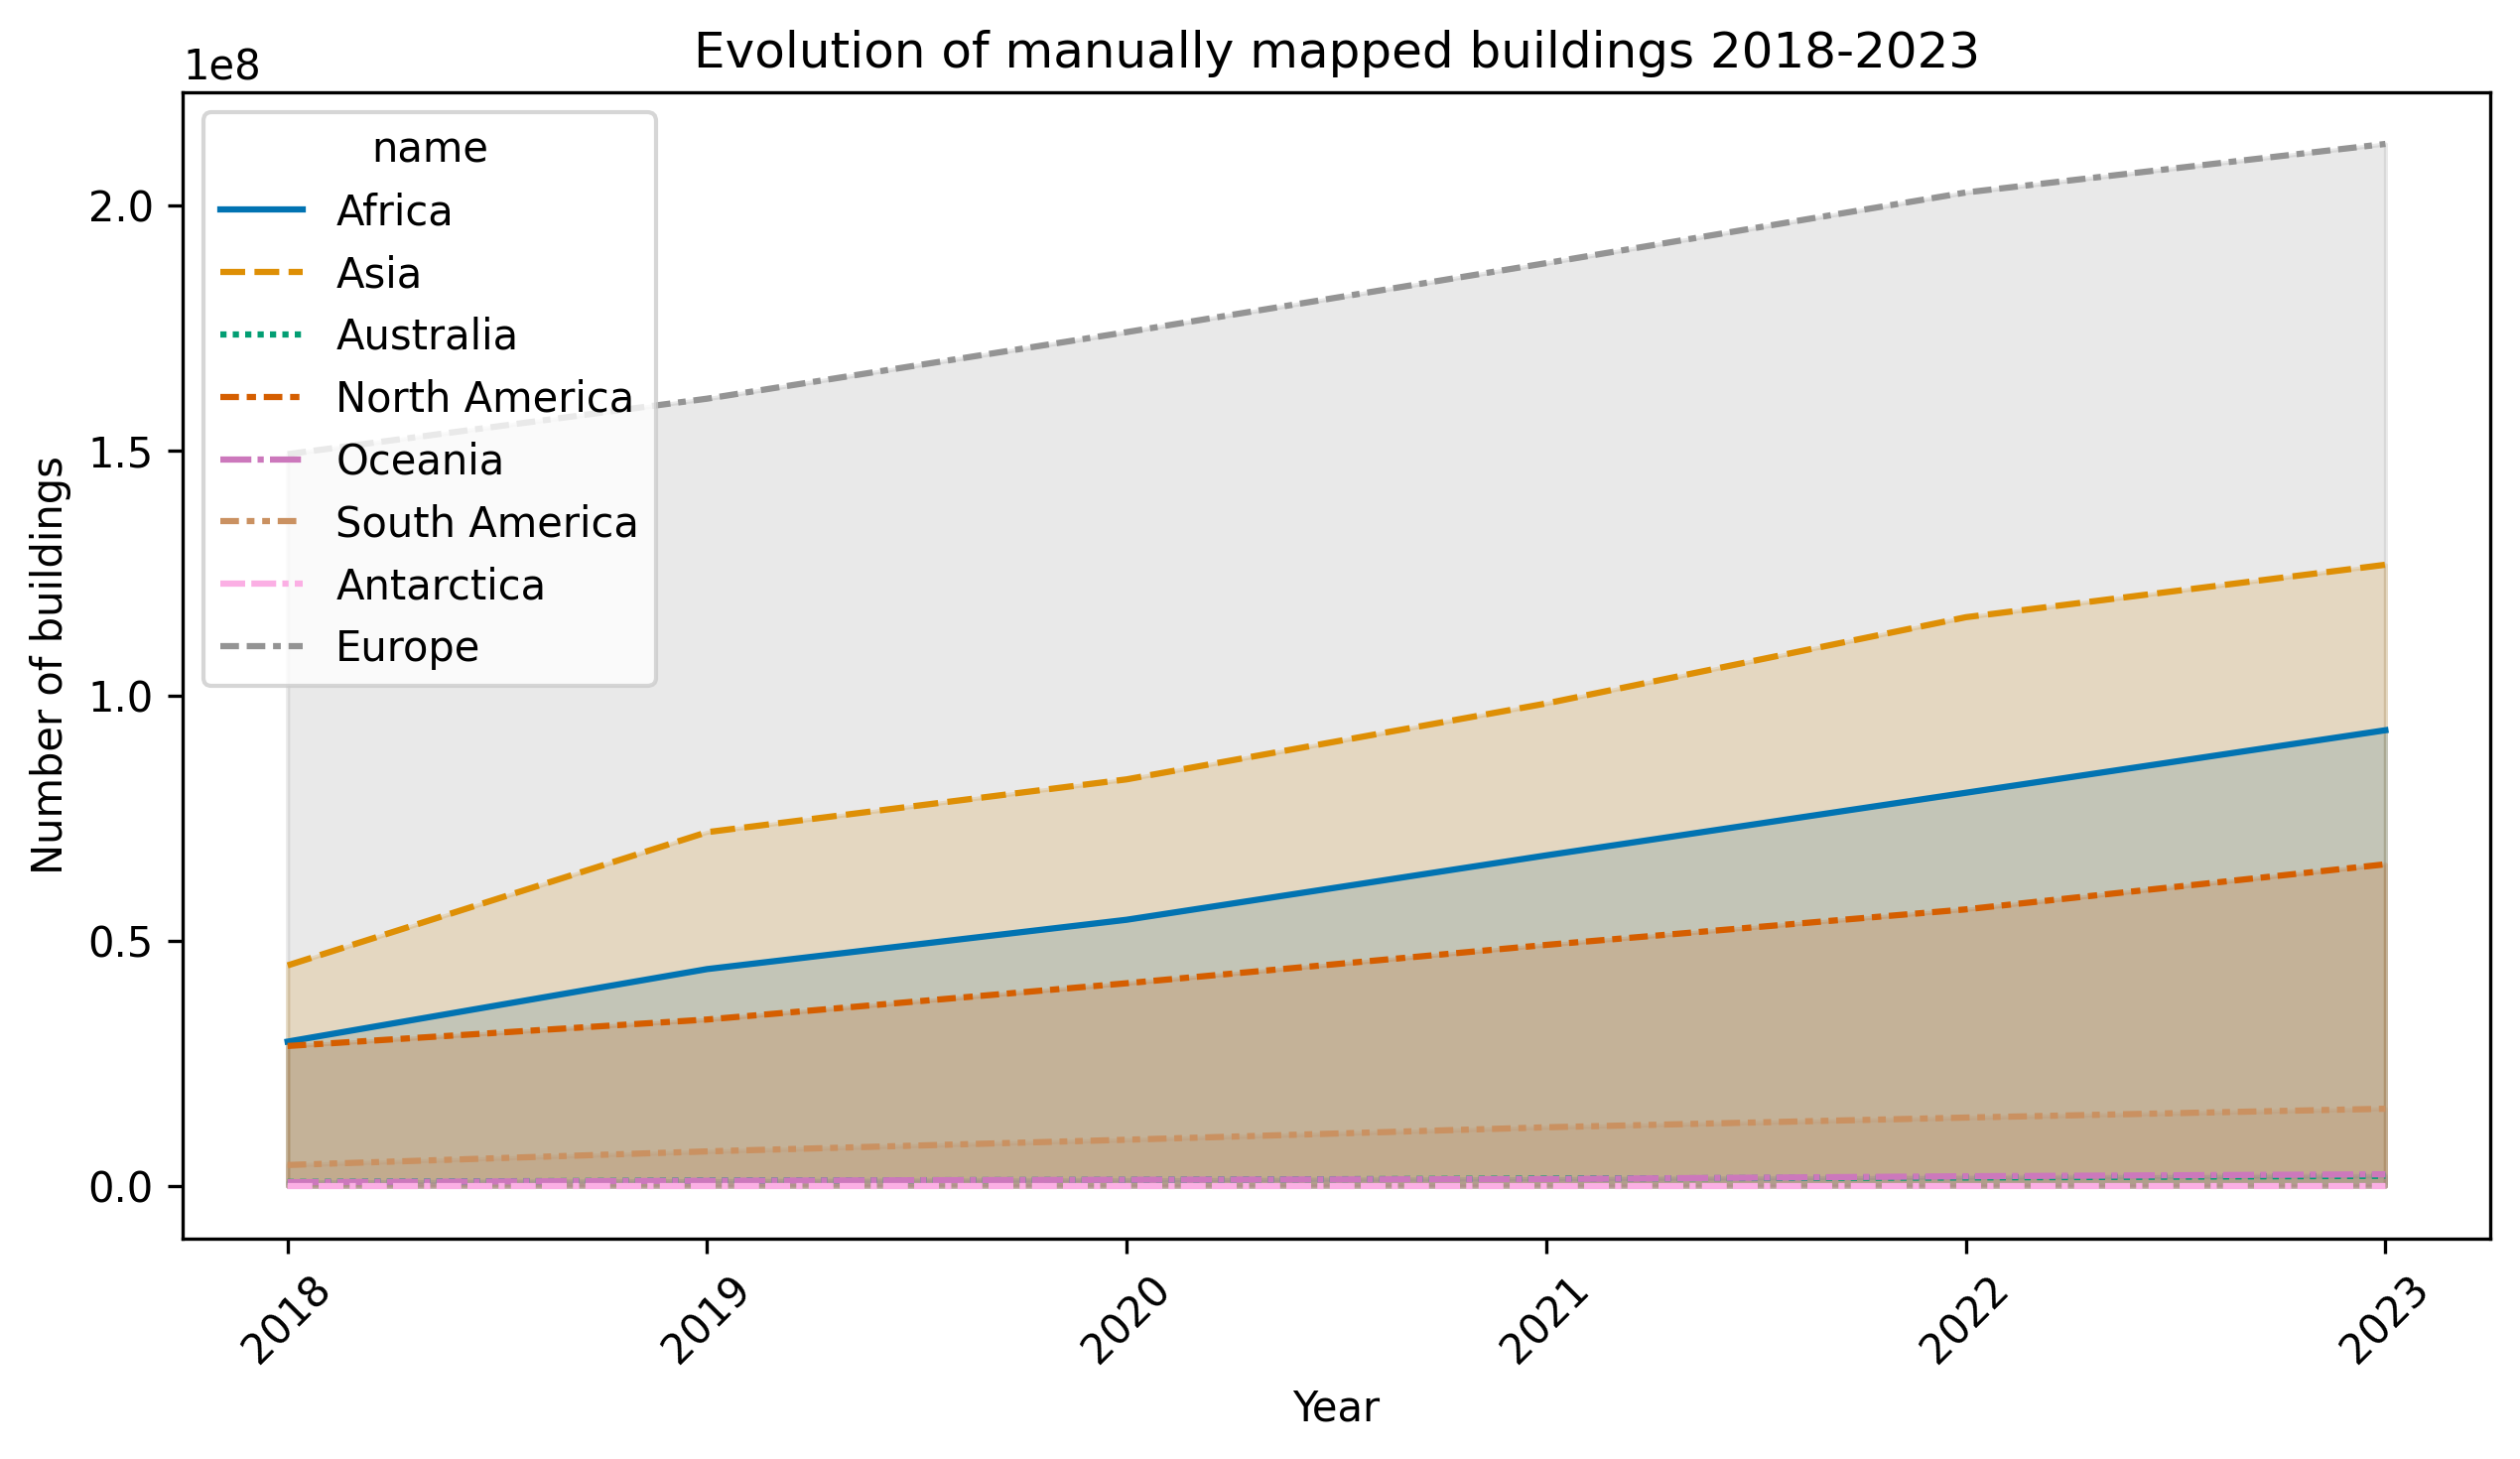

In [25]:
# without dictionary labels

plt.figure(figsize=(10, 5), dpi=300)
plt.title("Evolution of manually mapped buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_rem,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")


### AI Microsoft buildings

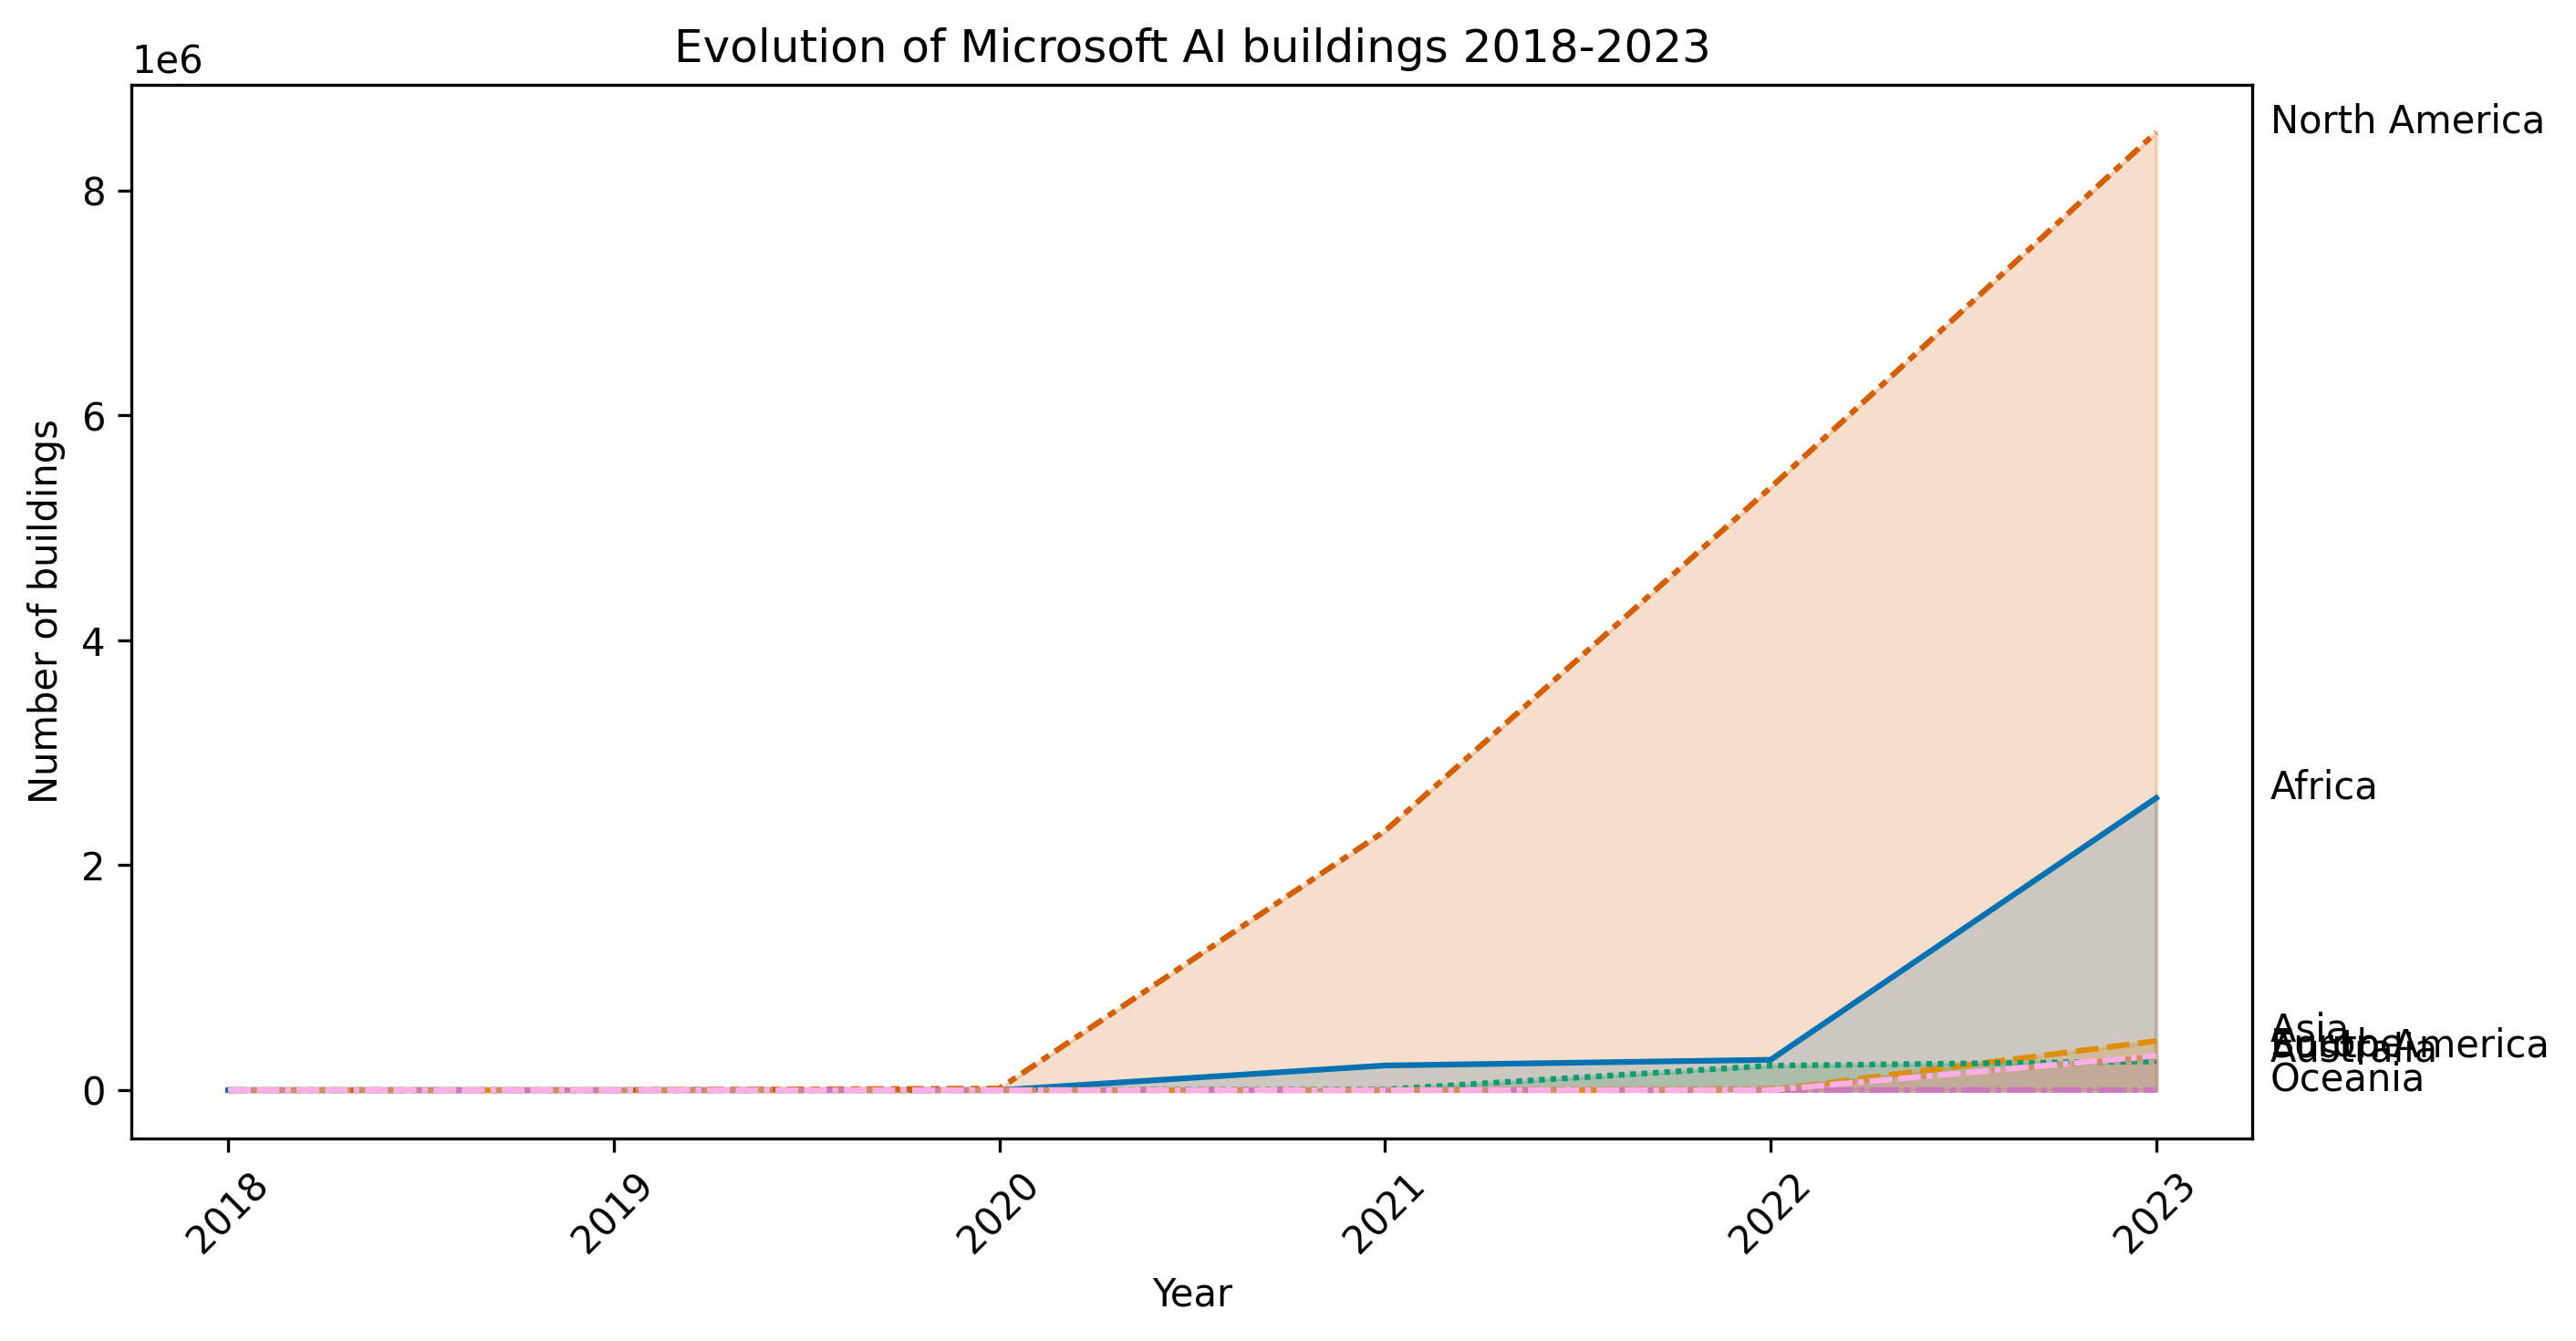

In [26]:
# test for labels at the line

plt.figure(figsize=(10, 5), dpi=300)
plt.title("Evolution of Microsoft AI buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_ai,
                  palette='colorblind',  style='name', legend=False
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# add annotations in the end of the lines
for i in range(len(df_last_ai)):
    ax.annotate(df_last_ai.iloc[i]['name'], xy=(df_last_ai.iloc[i]["year"], df_last_ai.iloc[i]
                ['num_of_blds']), xytext=(30, 0), textcoords='offset points')


# add colorful annotation
# for line, name in zip(ax.lines, df_last_ai["name"]):
#     y = line.get_ydata()[-1]
#     ax.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                 xycoords=ax.get_yaxis_transform(), textcoords="offset points",
#                 size=14, va="center")


# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")

plt.show()


Text(0, 0.5, 'Number of buildings')

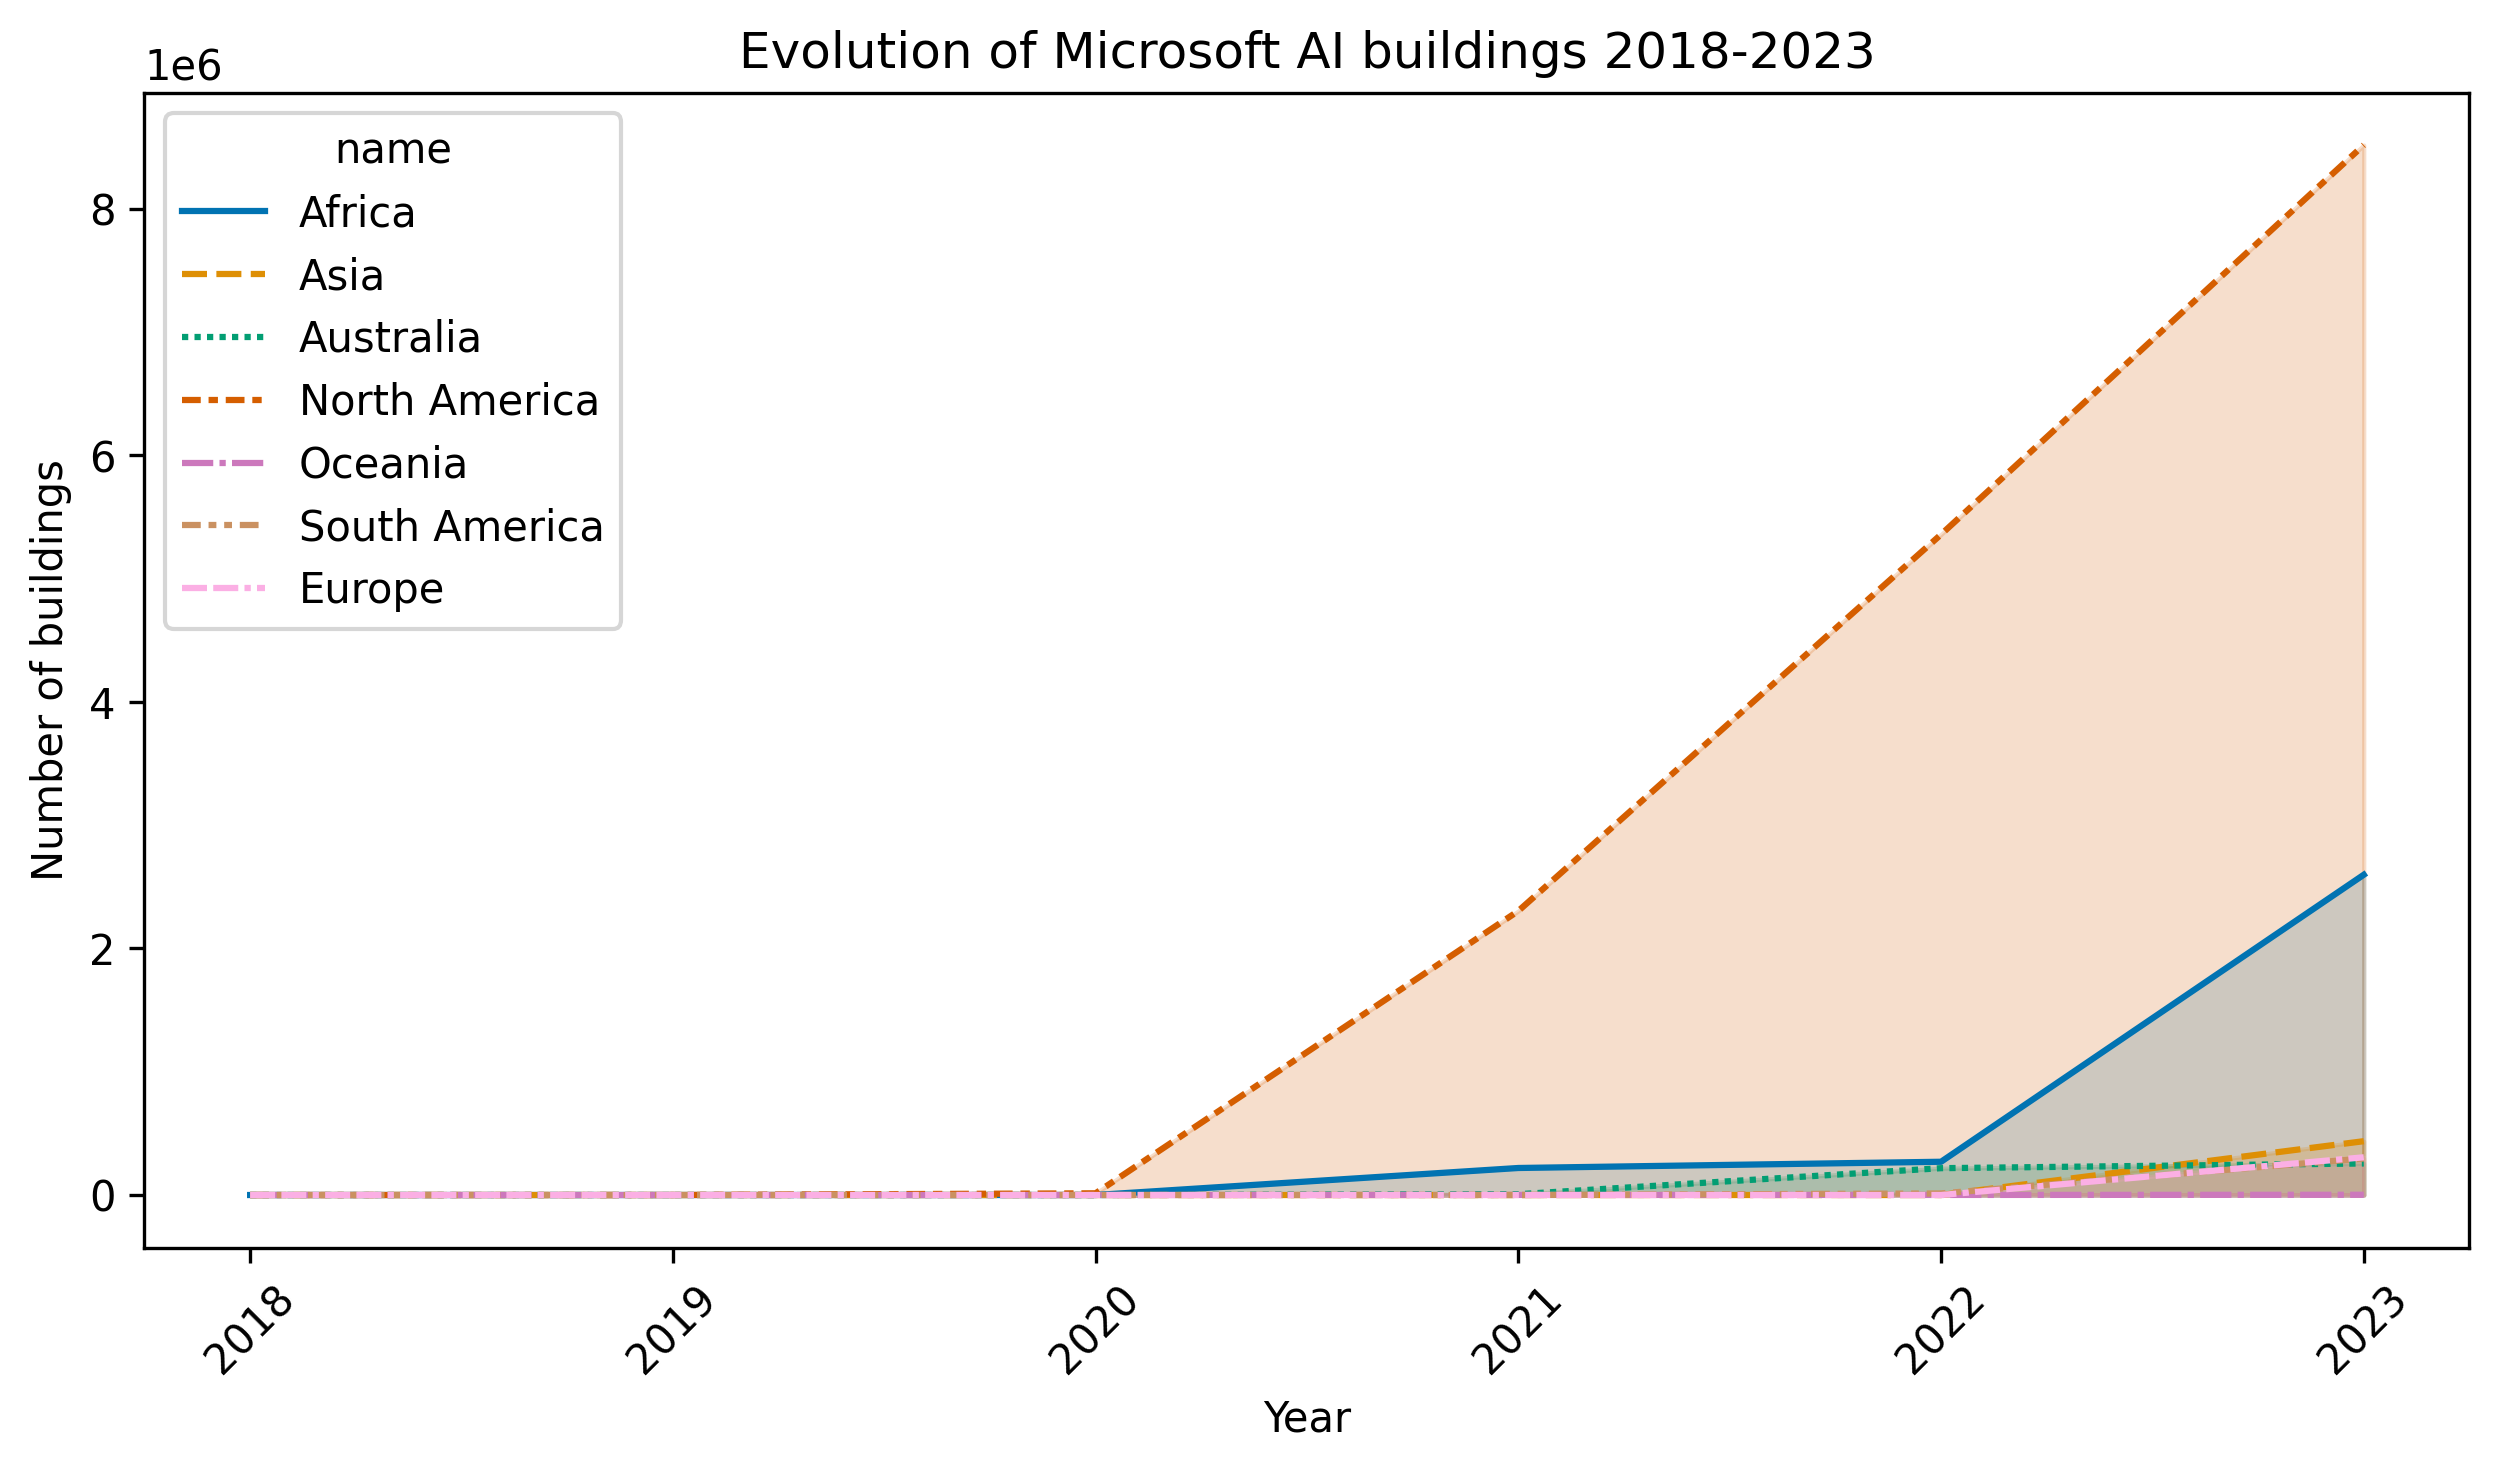

In [27]:
# without dictionary labels

plt.figure(figsize=(10, 5), dpi=300)
plt.title("Evolution of Microsoft AI buildings 2018-2023")

# plot the data
ax = sns.lineplot(x='year', y='num_of_blds', hue='name', data=df_ai,
                  palette='colorblind',  style='name',
                  )
# log y axis
# plt.yscale("log")

# rotate x labels
plt.xticks(rotation=45)
# plt.ylim(top=105)

# fill the area under lines
fill_under_lines(ax)

# set x and y axis labels
plt.xlabel("Year")
plt.ylabel("Number of buildings")


### AI Microsoft and Manually mapped buildings together

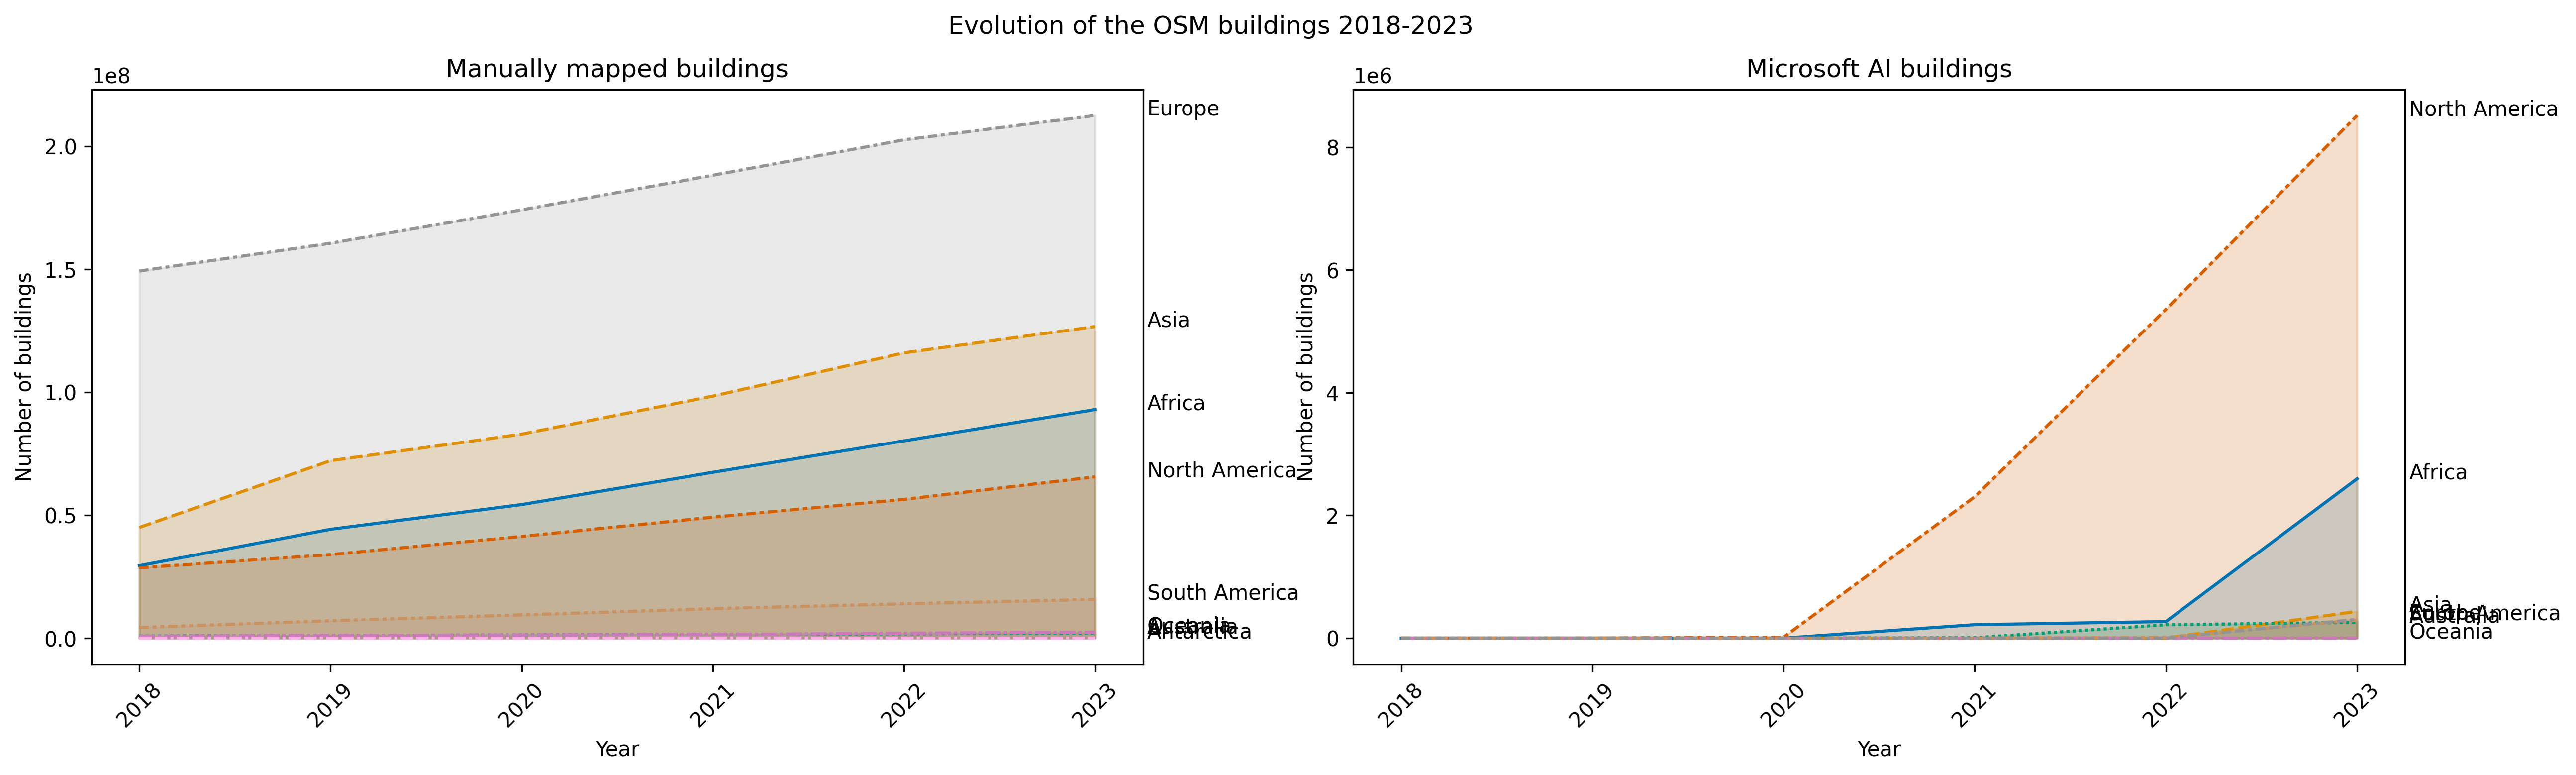

In [28]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(20, 5), dpi=300)
fig.suptitle("Evolution of the OSM buildings 2018-2023")

fig.subplots_adjust(hspace=2)

# create a Seaborn plot on the first subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_rem, ax=ax1,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys(),
             legend=False
             )

# create another Seaborn plot on the second subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_ai, ax=ax2,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys(),
             legend=False
             )


# ax1.set_yscale("log")
# ax2.set_yscale("log")

# set titles for each subplot
ax1.set_title("Manually mapped buildings")
ax2.set_title("Microsoft AI buildings")

# set the y axis limit
# ax1.set_ylim(top=105, bottom=-5)
# ax2.set_ylim(top=105, bottom=-5)

# set the y axis label
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of buildings")

# set the x axis label
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of buildings")

# fill the area under lines
fill_under_lines(ax1, ax2)

# rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelrotation=45)

# add colorful annotation
# for line, name in zip(ax1.lines, df_last_rem["name"]):
#     y = line.get_ydata()[-1]
#     ax1.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                  xycoords=ax1.get_yaxis_transform(), textcoords="offset points",
#                  size=14, va="center")

# for line, name in zip(ax2.lines, df_last_ai["name"]):
#     y = line.get_ydata()[-1]
#     ax2.annotate(name, xy=(1, y), xytext=(1, 0), color=line.get_color(),
#                  xycoords=ax2.get_yaxis_transform(), textcoords="offset points",
#                  size=14, va="center")



# add annotations in the end of the lines – ax1
for i in range(len(df_last_rem)):
    ax1.annotate(df_last_rem.iloc[i]['name'], xy=(df_last_rem.iloc[i]["year"], df_last_rem.iloc[i]
                ['num_of_blds']), xytext=(25, 0), textcoords='offset points')

# add annotations in the end of the lines – ax2
for i in range(len(df_last_ai)):
    ax2.annotate(df_last_ai.iloc[i]['name'], xy=(df_last_ai.iloc[i]["year"], df_last_ai.iloc[i]
    ['num_of_blds']), xytext=(25, 0), textcoords='offset points')

plt.show()


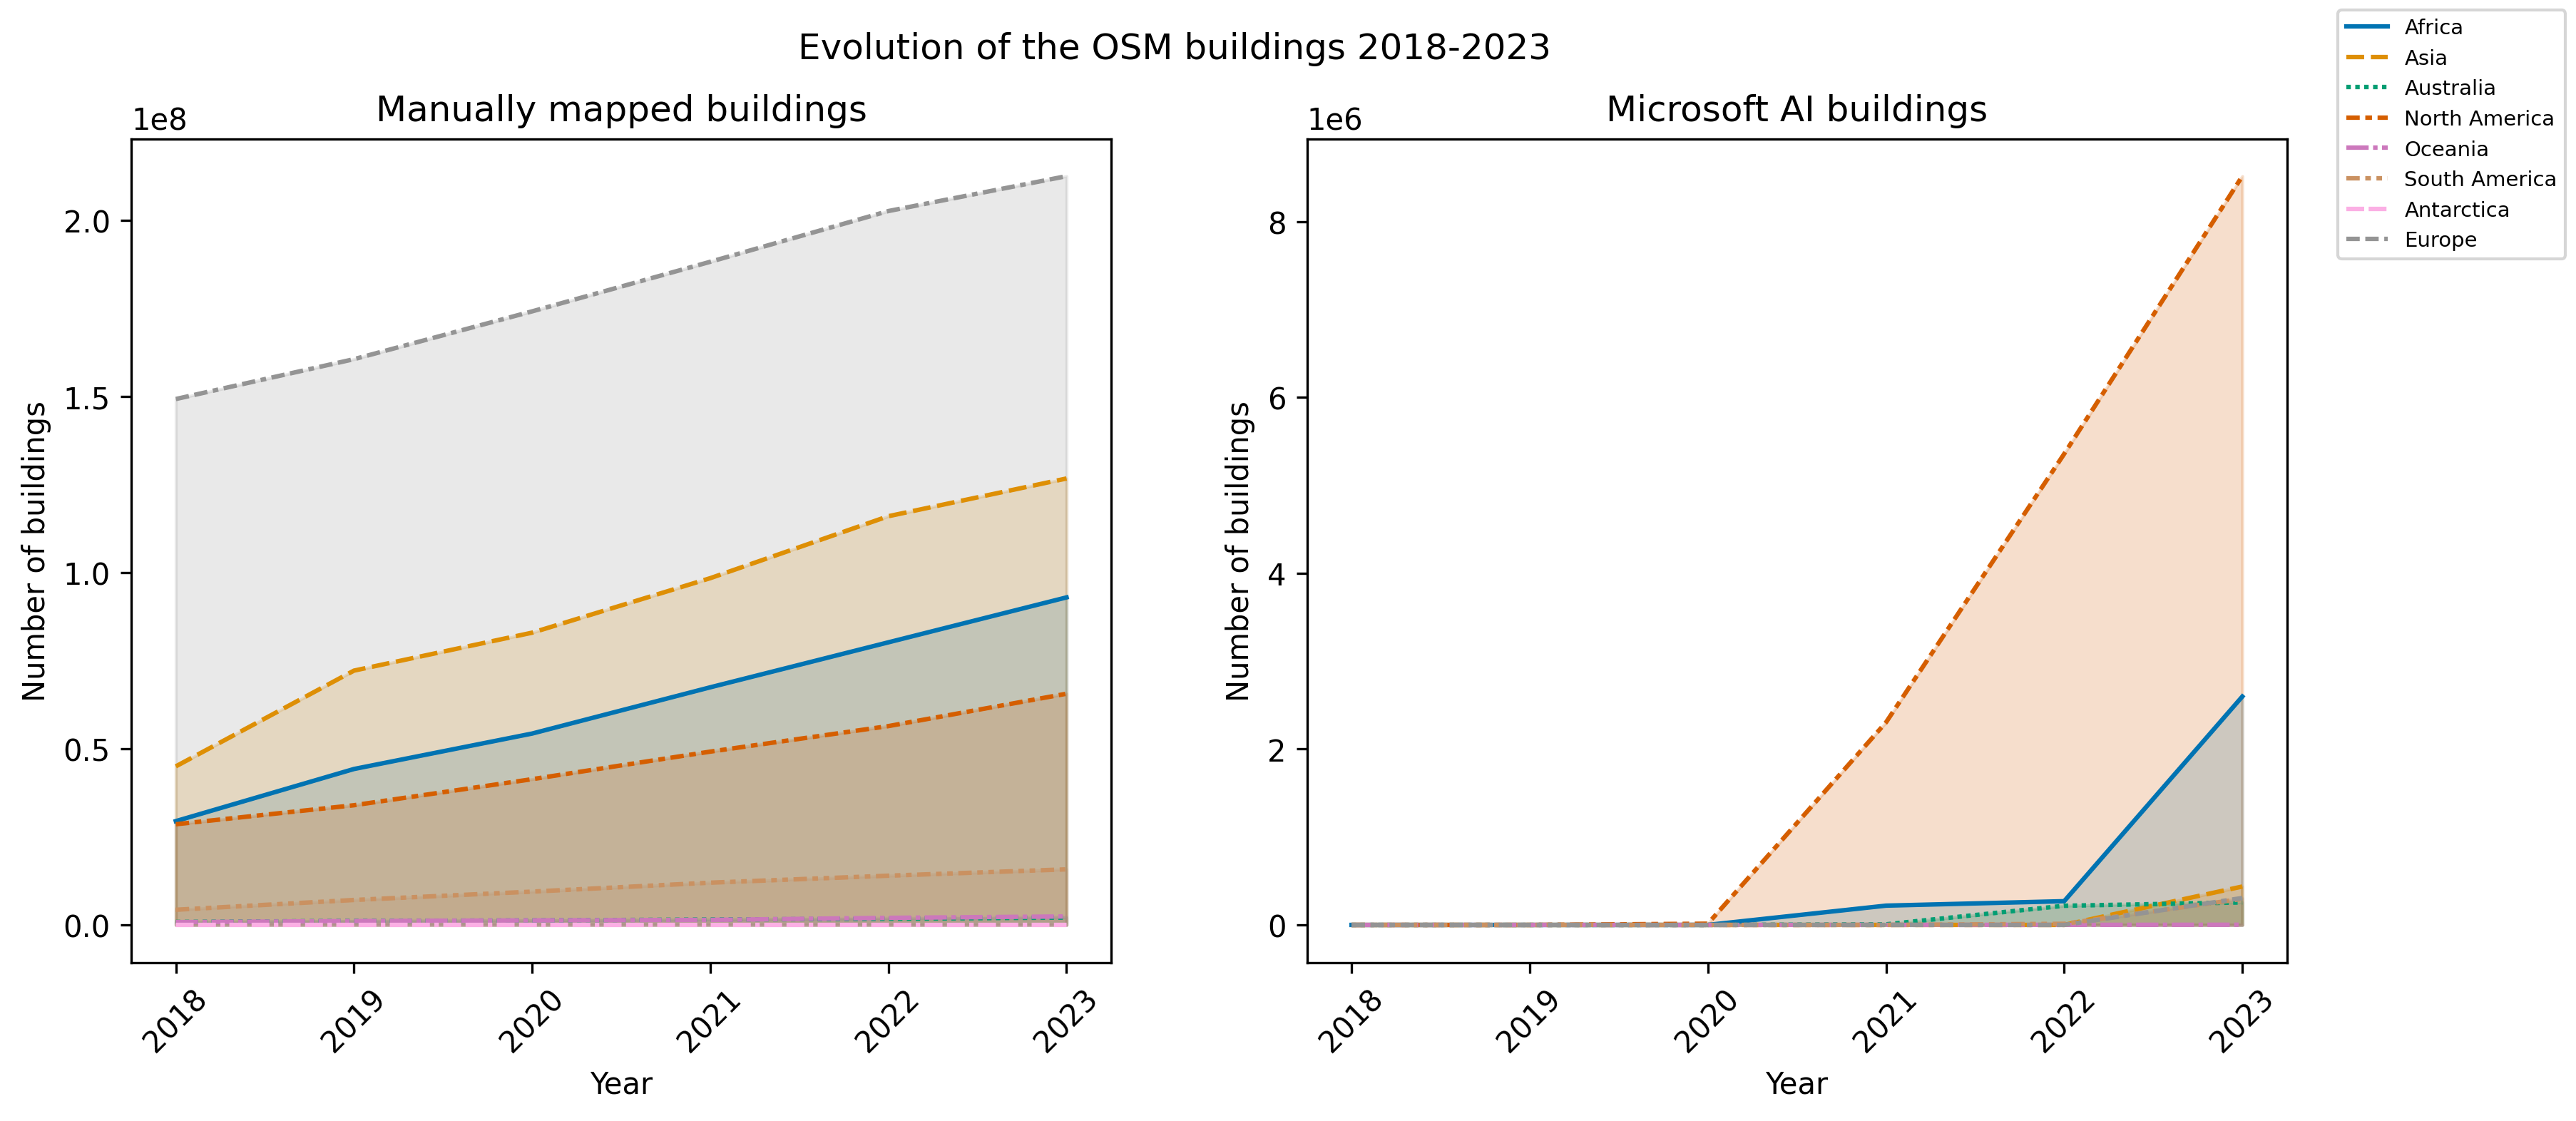

In [29]:
# create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(13, 5), dpi=300)
fig.suptitle("Evolution of the OSM buildings 2018-2023")

# create a Seaborn plot on the first subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_rem, ax=ax1,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys()
             )

# create another Seaborn plot on the second subplot
sns.lineplot(x='year', y='num_of_blds', hue='feature', data=df_ai, ax=ax2,
             palette='colorblind', style='feature',
             hue_order=id_name_dic.keys(),
             style_order=id_name_dic.keys())

# set the legend labels
handles, _ = plt.gca().get_legend_handles_labels()
ax2.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)
ax1.legend().remove()
ax2.legend().remove()

# ax1.set_yscale("log")
# ax2.set_yscale("log")

# set titles for each subplot
ax1.set_title("Manually mapped buildings")
ax2.set_title("Microsoft AI buildings")

# set the y axis limit
# ax1.set_ylim(top=105, bottom=-5)
# ax2.set_ylim(top=105, bottom=-5)

# set the y axis label
ax1.set_xlabel("Year")
ax1.set_ylabel("Number of buildings")

# set the x axis label
ax2.set_xlabel("Year")
ax2.set_ylabel("Number of buildings")

# fill the area under lines
fill_under_lines(ax1, ax2)

# rotate x-axis labels for both subplots
for ax in [ax1, ax2]:
    # ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.tick_params(axis='x', labelrotation=45)

fig.legend(handles, [id_name_dic[key]
           for key in id_name_dic.keys()], fontsize=7)

plt.show()
